In [44]:
import pandas as pd 
import numpy as np 
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [77]:
import os
from distutils.dir_util import copy_tree

# Define dataset paths
default_dir = "alzheimers-dataset/"
train_dir = os.path.join(default_dir, "train")  # Your dataset already has 4 folders
work_dir = "dataset/"  # This is where images will be copied

# ✅ Ensure the source directory exists
if not os.path.exists(train_dir):
    print("❌ Error: Train directory not found! Check the dataset path.")
else:
    # ✅ Remove and recreate work directory
    if os.path.exists(work_dir):
        remove_tree(work_dir)

    os.mkdir(work_dir)

    # ✅ Copy images from train_dir to work_dir
    copy_tree(default_dir, work_dir)  # Copy entire dataset folder

    print("✅ Images copied successfully!")
    print("📂 Working Directory Contents:", os.listdir(work_dir))


✅ Images copied successfully!
📂 Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'test', 'train', 'VeryMildDemented']


In [78]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176 

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [79]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [80]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 6400 images belonging to 6 classes.


## Visualization

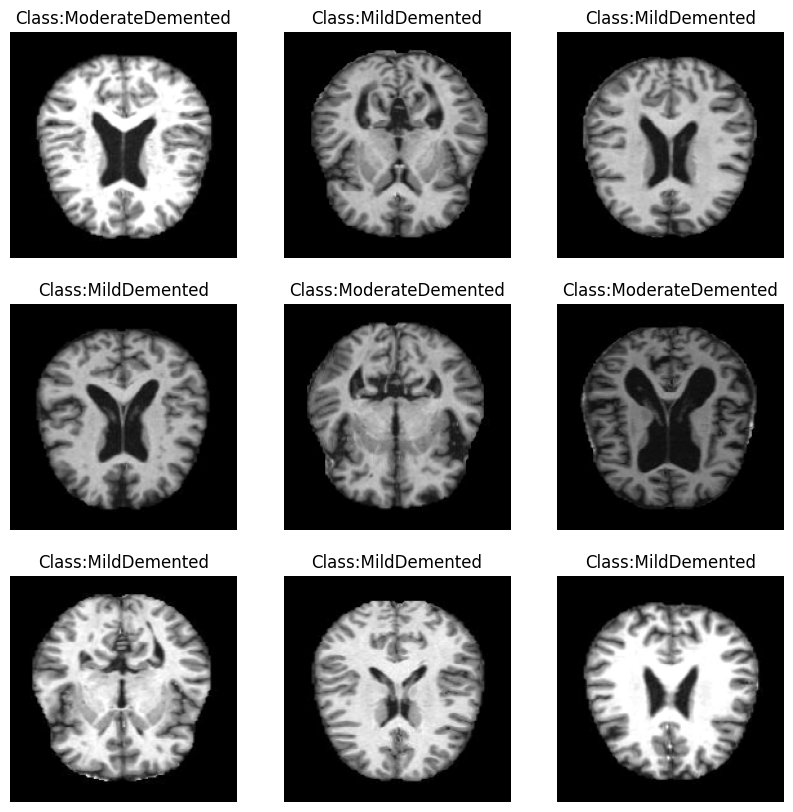

In [81]:
def show_images(generator, y_pred=None):
    labels = dict(zip([0, 1, 2, 3], CLASSES))

    # ✅ Fix: Use next(generator) instead of generator.next()
    x, y = next(generator)

    # Show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, len(x) - 1)  # ✅ Fix potential index error
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])], labels[y_pred[i]]))

# ✅ Display Train Images
show_images(train_dataset)


<BarContainer object of 4 artists>

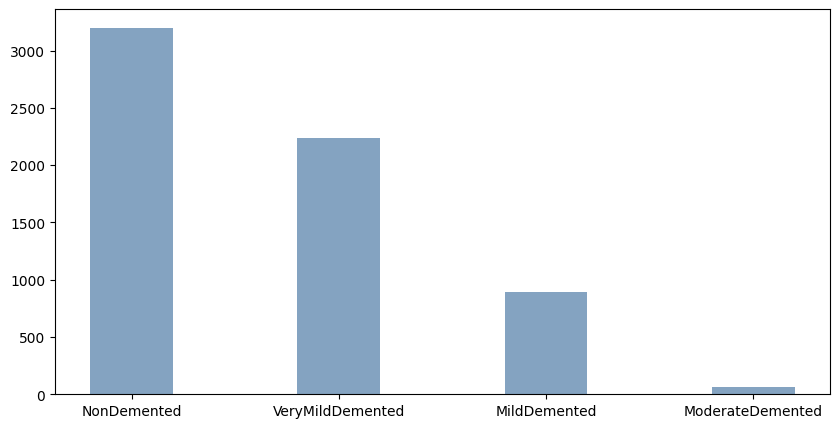

In [82]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

## Feature Engineering and Oversampling

In [86]:
train_data, train_labels = next(train_dataset)  # ✅ Correct


In [87]:
print(train_data.shape, train_labels.shape)

(1200, 176, 176, 3) (1200, 6)


In [88]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

c:\Users\Abhishek\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Abhishek\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Abhishek\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Abhishek\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, c

(2496, 176, 176, 3) (2496, 4)


In [89]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [90]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

c:\Users\Abhishek\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [92]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - acc: 0.2640 - auc: 0.5199 - loss: 1.9616 - val_acc: 0.2250 - val_auc: 0.4800 - val_loss: 1.4002
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - acc: 0.3221 - auc: 0.5762 - loss: 1.6910 - val_acc: 0.2250 - val_auc: 0.4850 - val_loss: 1.4052
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - acc: 0.3698 - auc: 0.6380 - loss: 1.4907 - val_acc: 0.2250 - val_auc: 0.4867 - val_loss: 1.4082
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - acc: 0.4629 - auc: 0.7204 - loss: 1.2748 - val_acc: 0.2250 - val_auc: 0.4875 - val_loss: 1.3928
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - acc: 0.4975 - auc: 0.7728 - loss: 1.1414 - val_acc: 0.2250 - val_auc: 0.4805 - val_loss: 1.4336
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - acc: 0.5624 - auc: 0.8196 - loss: 1.0004 - val_acc: 0.2250 - val_auc: 0.4800 - val_loss: 1.5026
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - acc: 0.5742 - auc: 0.8418 - loss: 0.9425 - va

In [93]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.7640 - auc: 0.9343 - loss: 0.8039
Loss:  0.9735840559005737
Accuracy:  0.7319999933242798


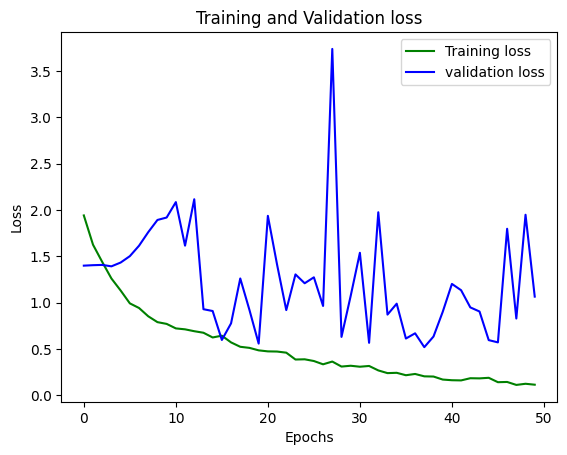

In [94]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

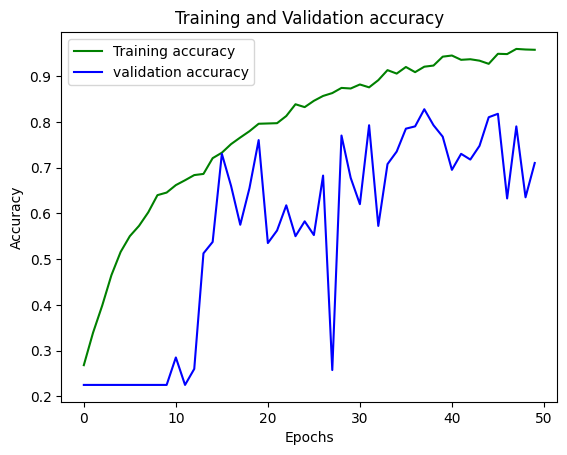

In [95]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [96]:
model.save('model.h5')

In [98]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Image path 
path = Path('dataset/ModerateDemented/moderateDem0.jpg')
img = image.load_img(path, target_size=(176,176))
image_array = img_to_array(img) / 255.0
image_array = np.expand_dims(image_array, axis=0)

img_array = image_array.reshape((1, 176, 176, 3))


predictions = model.predict(image_array)

#print(predictions)
predicted_label = train_labels[np.argmax(predictions)]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Abhishek\\Downloads\\Alzheimers-disease-detection-main\\Alzheimers-disease-detection-main\\dataset\\ModerateDemented\\moderateDem0.jpg'

In [5]:
import os
print("Current Directory:", os.getcwd())  # Shows the working directory
print("Contents:", os.listdir())  # Lists files/folders in the current directory

Current Directory: c:\Users\Abhishek\Downloads\Alzheimers-disease-detection-main\Alzheimers-disease-detection-main
Contents: ['alzheimer-detection.ipynb', 'Alzheimer_MRI_4_classes_dataset', 'app2.py', 'dataset', 'images', 'Pdf_reports', 'README.md']
